# 02: Understanding the data

This notebook contains all of the information necessary for understanding the data, its descriptive statistics and plotting light curves.

In [172]:
# importing all of the necessary libraries
import numpy as np
import seaborn as sns
import pandas as pd
import scipy as sc
import random
import pickle

from matplotlib import pyplot as plt
from scipy.stats import norm

from astroML.utils.decorators import pickle_results
from astroML.time_series import search_frequencies, lomb_scargle, MultiTermFit
from astroML.datasets import fetch_LINEAR_sample

from ztfquery import lightcurve
from matplotlib import ticker

np.random.seed(42)
%matplotlib inline  

In [2]:
sns.set_theme() # setting the theme for plotting

# LINEAR data

### A bit about LINEAR

The LINEAR dataset (Lincon Near-Earth Asteroid Research) used in this research paper contains 7010 light curves of periodic variable stars. While the original mission of this survey was to find asteroids, it subsequently monitored a very large portion of the sky, catalouging the brightness of various variable stars. This survey operated with 2 telescopes on a site in New Mexico. The 2 telescopes are equatorialy mounted of GEODSS type, where each telescope is denoted as L1 and L2. They observed in a broad part of the visible spectrum and of the near-infrared spectrum. 

The preprocessing process contained the following procedures:
1. Bias correction: removing noise created by the camera
2. Flat-field correction: removing artificial lines and gradients due to varying sensitivities of pixels
3. Preliminary fixed-aperature photometry: substracting the background light using poisson statistics

After preprocessing, the data had to be astrometrically recalibrated. This means that the scientists had to ensure the coordinates of the objects in the data match another survey, like SDSS. Of all the data, 7% had bad astrometry (the coordinates did not match up), so they were removed from the dataset. The rest of the data had a 1-2% error in astrometry.

Next up was photometric recalibration. This means that the filters and fluxes had to be recalibrated to match SDSS data. The corrections regarded CCD camera errors, correcting the magnitudes of objects in the data and correcting underestimated magnitude errors. After the photometric recalibration, the data was grouped into various categories, including a variable star category. While the original dataset has 5 billion objects, only 7010 are confirmed periodic variable stars. This portion of the dataset was subsequently analysed. Scientists deterimned the categories of the light curves, the periods of the stars, and other factors. 

## Downloading the data

Downloading the data only requires one line of code, since we are downloading the data from the AstroMl library.

In [3]:
# fetching the data and saving it in the inputs folder
data = fetch_LINEAR_sample(data_home='/Users/emadonev/Library/Mobile Documents/com~apple~CloudDocs/PROJECTS/var_stars/inputs') # fetching the data from astroML data library

[=========================================]  303.4kb / 303.4kb   
[=========================================]  16.05Mb / 16.05Mb   


We are accessing the data throught the `AstroML` library, since the creators of the library have already organised and prepared the data.

In [4]:
# acessing all of the light curves from the data and checking if any light curve is missing
c = 0 # setting the counter to 0
for i in data.ids: # iterating through all of the data ID's
    light_curve = data.get_light_curve(i) # fetching the light curve data for a specific ID
    c += 1 # updating the counter
    print(light_curve[:1]) # printing the first row of the light curve
print(c) # printing the result of the counter

[[5.26514326e+04 1.57560000e+01 3.50000000e-02]]
[[5.26524776e+04 1.65340000e+01 5.90000000e-02]]
[[5.26374598e+04 1.54500000e+01 4.48000000e-01]]
[[5.26524564e+04 1.48020000e+01 1.10000000e-02]]
[[5.2652457e+04 1.3849000e+01 6.0000000e-03]]
[[5.26524571e+04 1.57110000e+01 2.60000000e-02]]
[[5.26644199e+04 1.60240000e+01 8.90000000e-02]]
[[5.26534613e+04 1.54790000e+01 2.00000000e-02]]
[[5.26534613e+04 1.50940000e+01 1.30000000e-02]]
[[5.26534612e+04 1.57050000e+01 2.40000000e-02]]
[[5.26534612e+04 1.60910000e+01 3.50000000e-02]]
[[5.26534609e+04 1.51110000e+01 1.70000000e-02]]
[[5.26534617e+04 1.69120000e+01 6.70000000e-02]]
[[5.26534608e+04 1.53420000e+01 1.70000000e-02]]
[[5.26534607e+04 1.50940000e+01 1.30000000e-02]]
[[5.26534608e+04 1.57890000e+01 2.80000000e-02]]
[[5.26134521e+04 1.67090000e+01 7.80000000e-02]]
[[5.26134521e+04 1.61110000e+01 4.40000000e-02]]
[[5.26675229e+04 1.65260000e+01 8.40000000e-02]]
[[5.26464943e+04 1.74710000e+01 1.58000000e-01]]
[[5.2646479e+04 1.54980

The counter has printed the number `7010`, which is the correct amount of light curves in this dataset. This means no light curves are missing!

Our data contains 3 columns: `time`, `magnitude` and `magnitude_error`.

## Introductory information about the data

Before we begin with the statistical analysis of the data, it is important to look into the measurements themselves. In this section we will analyse the periods of the observation of each star, the amount of observations and the distribution of observations.

In [5]:
# counting the number of measurements of each light curve
p = []
for i in data.ids:
    lc = data.get_light_curve(i)
    t, m, me = lc.T
    p.append(len(t))

In [6]:
total_obser = sum(p)
print(total_obser)

1851936


Our dataset contains 1 851 936 observations!

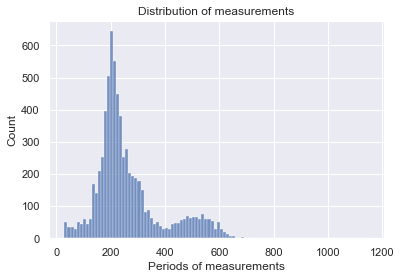

In [7]:
sns.histplot(data=p,bins=100)
plt.title('Distribution of measurements')
plt.xlabel('Periods of measurements')
plt.show()

From the graph above, we can see that most of our light curves have around 200 to 300 measurements, with a subsequent peack at around 500 measurements per light curve.

In [8]:
# calculating the actuall time difference between the first and last observation.

tm = []
for i in data.ids:
    lightc = data.get_light_curve(i)
    t, m, me = lightc.T
    time = t[len(t)-1] - t[0]
    tm.append(time)

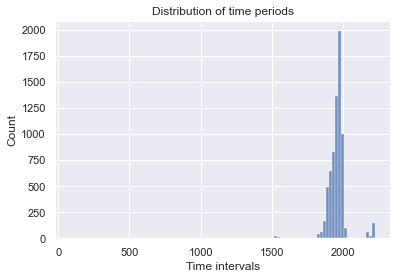

In [9]:
sns.histplot(data=tm,bins=100)
plt.title('Distribution of time periods')
plt.xlabel('Time intervals')
plt.show()

From this graph we can see that most of our time intervals span around 1800 to 2000 days. This means that no matter the type of variable star, most of the actual time intervals are very long.

In [10]:
time_diff = []
for i in data.ids:
    lc = data.get_light_curve(i)
    t, m, me = lc.T
    j=0
    tm = []
    while j<len(t):
        diff = t[j+1] - t[j]
        tm.append(diff)
        j += 1
        if j==len(t)-1:
            j=len(t)+1
    time_diff.append((sum(tm)/len(tm)))


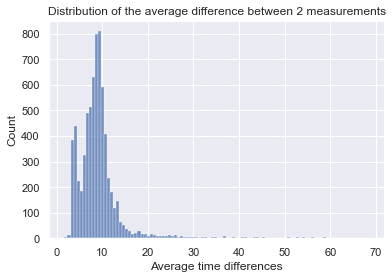

In [11]:
sns.histplot(data=time_diff,bins=100)
plt.title('Distribution of the average difference between 2 measurements')
plt.xlabel('Average time differences')
plt.show()

From the graph above we can see that most of our light curves have an average of 10 days between 2 measurements, however a large amount also have an average difference of around 4 to 5 days. There are small amounts which have a significant average difference between 2 measurements. However, it is worth keeping in mind that during these light curves there are large gaps in measurements, which **highly influence the average!**. 

In [12]:
time_diff = []
for i in data.ids:
    lc = data.get_light_curve(i)
    t, m, me = lc.T
    j=0
    tm = []
    while j<len(t):
        diff = t[j+1] - t[j]
        tm.append(diff)
        j += 1
        if j==len(t)-1:
            j=len(t)+1
    time_diff.append(np.median(tm))


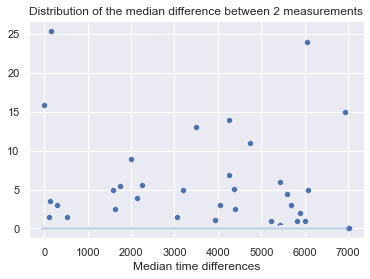

In [13]:
sns.scatterplot(data=time_diff)
plt.title('Distribution of the median difference between 2 measurements')
plt.xlabel('Median time differences')
plt.show()

Because of the reason mentioned in the last paragraph, I thought calculating the median would be a more appropriate metric. The graph above shows that **almost all of our measurements, save for a few, have a median value of around 0.** None of the values are really 0, however when they are rounded up, the difference between 2 measurements is a very small change. The bottom "line" represents the proportion of values whose median is 0, and the rest of the dots which are not 0. 

## Descriptive statistics of light curves

Before we begin with the calculation of periods and with analyzing the data, it is important to understand how it looks like. We accomplish this using *descriptive statistics*. Here, we are going to look at the statistics of `magnitude` values and `magnitude_error` values. The quantities are the `mean`, `median`, `standard deviation`, `minimum`, `maximum`, `rms scatter`, `skewness` and `kurtosis`.

#### Creating a descriptive statistics table for Magnitude values

In [14]:
descriptive_stats_mag = pd.DataFrame(columns=['mean', 'median', 'std', 'min', 'max', 'skew', 'kurtosis']) # creating an empty DataFrame where all of the stats will go

In [15]:
for i in data.ids: # looping over the id's of the dataset
    light_curve = data.get_light_curve(i) # getting the light curve information
    df = pd.DataFrame(light_curve.T[1], columns=[i]) # creating a table for every light curve
    dt = df.agg([np.mean, np.median, np.std, np.min, np.max]) # calculating the statistics for every value in the magnitudes column
    dt = dt.transpose()
    dt['skew'], dt['kurtosis'] = sc.stats.skew(df[i]), sc.stats.kurtosis(df[i])
    descriptive_stats_mag = pd.concat([descriptive_stats_mag, dt], axis=0) # add the data to the existing table
descriptive_stats_mag # print the table

,mean,median,std,min,max,skew,kurtosis
10003298,15.920224,15.8880,0.159858,15.679,16.360,0.659768,-0.482567
10004892,16.839543,16.8440,0.236847,16.382,17.975,0.767109,3.528837
10013411,15.574235,15.5020,0.192148,15.400,16.391,2.227095,4.286783
10021274,14.939383,14.9885,0.231373,14.289,15.330,-0.624265,-0.566168
10022663,14.253744,14.2935,0.227889,13.698,14.665,-0.550420,-0.498097
...,...,...,...,...,...,...,...
9983476,16.105178,16.2230,0.269350,15.256,16.447,-1.299098,0.957857
9983939,15.392084,15.3705,0.146921,15.021,15.666,0.001482,-0.838033
9984569,16.878944,16.8865,0.185500,16.015,17.461,-0.272009,0.448430
9987252,16.536356,16.6190,0.233660,15.898,17.009,-0.716311,-0.493886


#### Creating a descriptive statistics table for Error values

In [16]:
descriptive_stats_error = pd.DataFrame() # creating an empty DataFrame where all of the stats will go

In [17]:
for i in data.ids: # looping over the id's of the dataset
    light_curve = data.get_light_curve(i) # getting the light curve information
    df = pd.DataFrame(light_curve.T[2], columns=[i]) # creating a table for every light curve
    dt = df.agg([np.mean, np.median, np.std, np.min, np.max]) # calculating the statistics for every value in the magnitudes column
    dt = dt.transpose()
    dt['skew'], dt['kurtosis'] = sc.stats.skew(df[i]), sc.stats.kurtosis(df[i])
    descriptive_stats_error = pd.concat([descriptive_stats_error, dt], axis=0) # add the data to the existing table
descriptive_stats_error # print the table

,mean,median,std,min,max,skew,kurtosis
10003298,0.048587,0.0440,0.018496,0.018,0.115,1.239252,1.627132
10004892,0.109491,0.0980,0.053818,0.039,0.332,1.606721,3.142803
10013411,0.039447,0.0280,0.042827,0.015,0.448,6.871714,56.888840
10021274,0.020528,0.0200,0.009136,0.009,0.056,1.671405,3.435779
10022663,0.012114,0.0110,0.005738,0.006,0.043,2.365310,8.099770
...,...,...,...,...,...,...,...
9983476,0.050059,0.0470,0.022007,0.018,0.170,1.708778,4.963436
9983939,0.026773,0.0240,0.014607,0.011,0.196,6.996748,72.122555
9984569,0.098475,0.0910,0.044793,0.041,0.554,3.751263,26.878901
9987252,0.069002,0.0650,0.028730,0.028,0.198,1.768121,4.405388


#### Assigning the index column

In [18]:
# adding the name 'index' to the column of indexes
descriptive_stats_mag.index.name='index'
descriptive_stats_error.index.name='index'

#### Adding a maximum amplitude column to the data

In [19]:
# creating a new column Amplitude where we substract the min value from the max value
descriptive_stats_mag['Amplitude'] = descriptive_stats_mag['max'] - descriptive_stats_mag['min']
descriptive_stats_error['Amplitude'] = descriptive_stats_error['max'] - descriptive_stats_error['min']

## Analyzing descriptive statistics of light curves

## Analysis of magnitude values

In [20]:
# the list of columns
columns = ['mean', 'median', 'std', 'min', 'max', 'skew','kurtosis','Amplitude']

### Histograms of all the properties

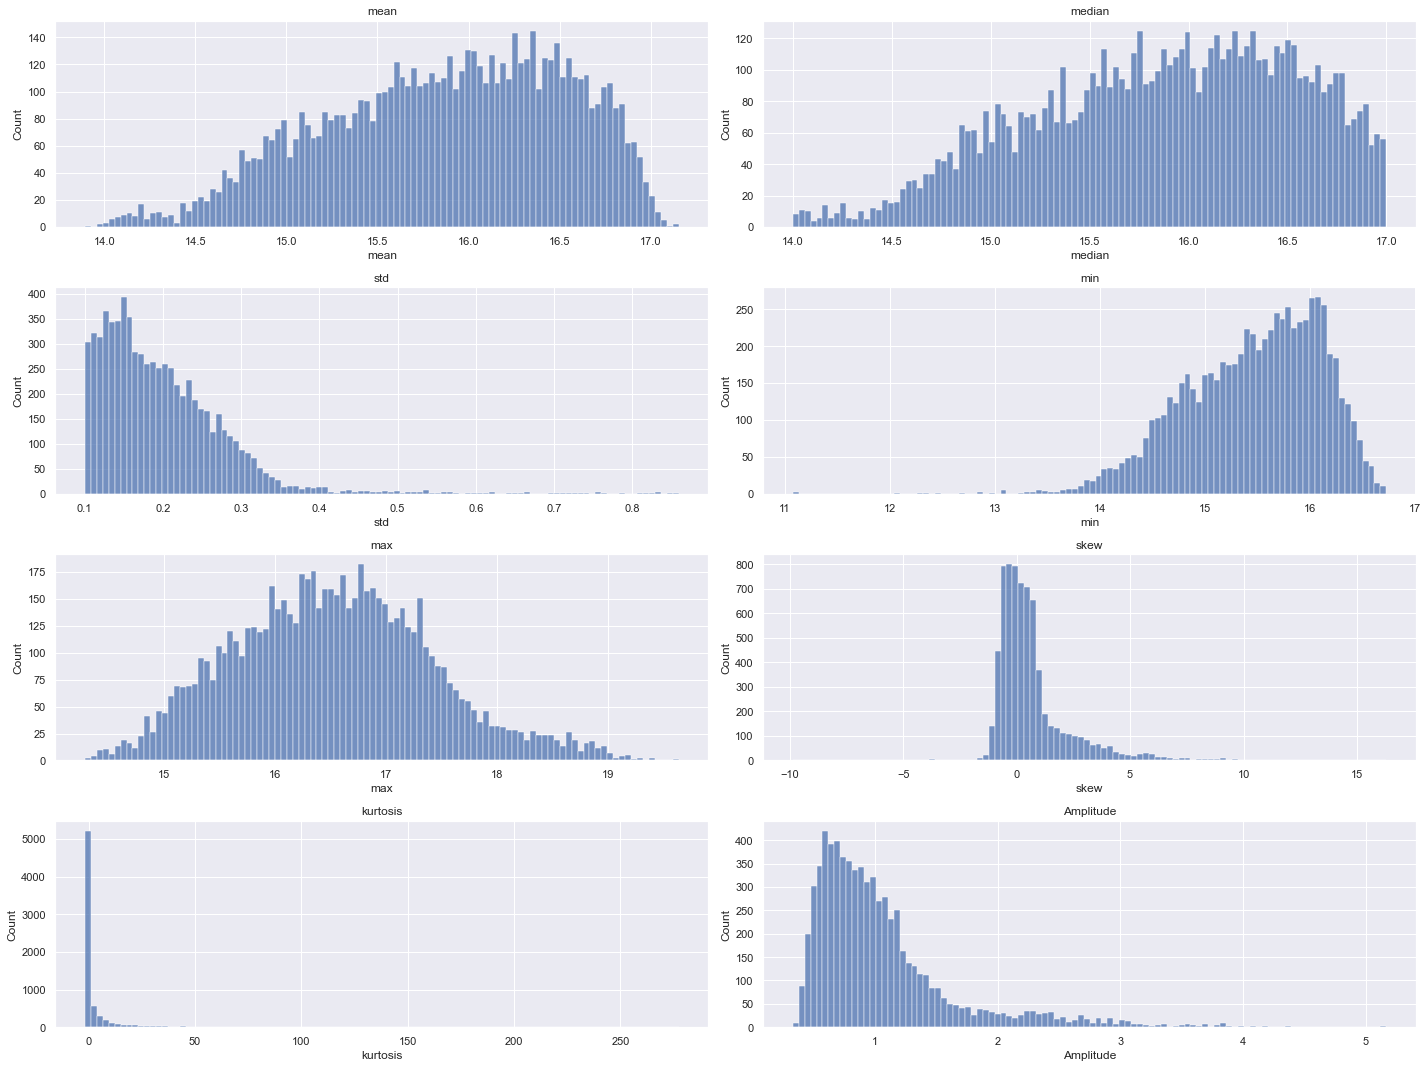

In [21]:
fig, ax = plt.subplots(4,2, figsize=(20,15)) # creating subplots with 2 columms and 3 rows
ax = ax.flatten() # flatten the axes
for i in range(len(columns)): #plot the same type of graph for every property
    ax[i].set_title(columns[i])
    sns.histplot(data=descriptive_stats_mag,x=columns[i],bins=100,ax=ax[i])
plt.tight_layout()
plt.show()

From the graphs above, we can make a few observations.
1. The mean graph is skewed towards the left, where most light curves have a mean of 16 to 16.5 magnitudes.
2. The median graph is also skewed towards the left, where most light curves have a median of around 16 to 16.5 magnitudes, same as the mean. This means that the mean is not heavily influenced by outliers.
3. The standard deviation is heavily skewed towards the right, where most light curves have a standard deviation of around 0.1 to 0.2. Since the standard deviation is so small, it means that most of our data is concentrated around the mean, which is 16-16.5 magnitudes. 
4. The minimum value is skewed towards the left, where most light curves have a minimum of around 16 magnitudes. Since the minimum of a light curve is so close to the mean, it means most of our amplitudes are most likely small, which is shown in the final graph.
5. The maximum value is centered, where most light curves have a maximum from 16.5 to 17.5. As with the observation from the previous graph, we can see that most values are very close to the mean, indicating a small amplitude.
6. Most of the light curves fall into the range from -0.5 to 0.5, meaning that they are almost normally distributed, or symmetrical. However, a large portion of light curves are also outside of this range, from -1 to 1, meaning they are slightly skewed, or slightly asymmetrical. A very small amount of light curves are very asymmetrical.
7. The graph of kurtosis is heavily skewed to the right, where many light curves have a value of around 0. This means that most of our light curves are close to the normal distribution. However, a large portion of the light curves are more peaked than the normal distribution, since values of kurtosis are positive. 
8. In the final graph of amplitude, we can see that is is very skewed towards the right. Most light curves have an amplitude from approximately 0.4 to 1.3, meaning that our dataset contains few long period variables since they have a larger magnitude change. This also indicates that no cataclysmic variables are present, since no amplitude is greater than 5 magnitudes. 

#### Plotting a few distributions of light curves

We are plotting the magnitude distribution of a few light curves so that we can visualize the effect of the parameters on actual samples of the data.

In [22]:
listi = [ random.choice(data.ids) for i in range(6)]
listi

[465267, 10543030, 21028253, 9912772, 18912216, 23581289]

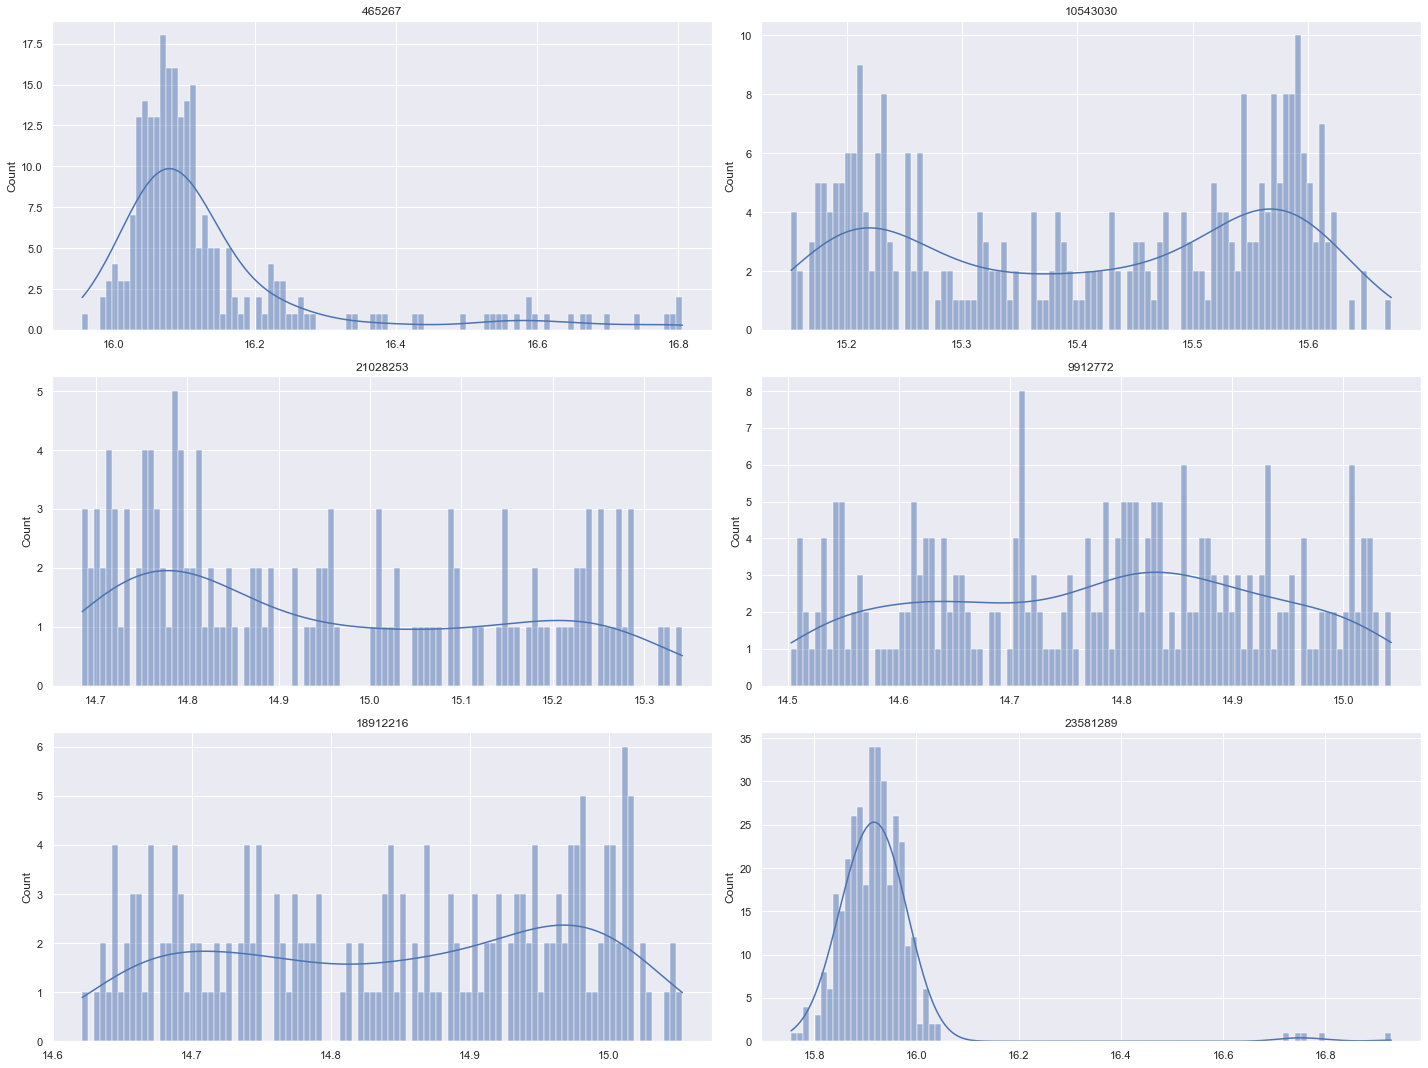

In [23]:
fig, ax = plt.subplots(3,2, figsize=(20,15)) # creating subplots with 2 columms and 3 rows
ax = ax.flatten() # flatten the axes
for i in range(6): #plot the same type of graph for every property
    lc = data.get_light_curve(listi[i])
    ax[i].set_title(listi[i])
    sns.histplot(data=lc.T[1],bins=100,ax=ax[i], kde=True)
plt.tight_layout()
plt.show()

From the graphs above we can see just how varied every light curve is. In this sample, there are no perfect normal distributions, and we can see how each light curve is differently skewed and centered. This reflects the varied results in the previous graphs, and the fact that none of these have very extreme values. 

### Correlations between parameters

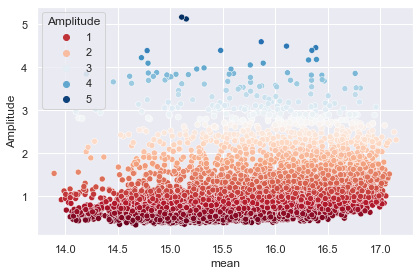

In [24]:
# Mean vs. amplitude
sns.scatterplot(
        data=descriptive_stats_mag,
        x='mean',
        y='Amplitude',
        palette='RdBu',
        hue='Amplitude')
plt.tight_layout()
plt.show()

From the graph above, we can see that there is no correlation between the mean and the amplitude. Near the end, there is a slight increase in amplitude as the mean grows, but this is very small compared to the rest of the dataset. 

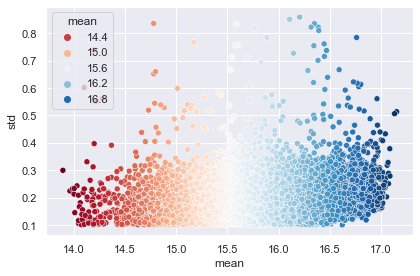

In [25]:
# mean vs. std
sns.scatterplot(
        data=descriptive_stats_mag,
        x='mean',
        y='std',
        palette='RdBu',
        hue='mean')
plt.tight_layout()
plt.show()

In the graph above, we compare the mean and the standard deviation. Here we also see no correlation, as the mean increases the standard deviation stays mostly the same, with a few points which have higher values. 

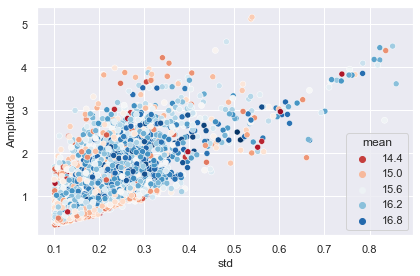

In [26]:
# std vs. amplitude
sns.scatterplot(
        data=descriptive_stats_mag,
        x='std',
        y='Amplitude',
        palette='RdBu',
        hue='mean')
plt.tight_layout()
plt.show()

However, in the graph above, we notice an interesting observation. As the standard deviation increases, or the distribution becomes more spread out, the amplitude of the light curves also increases, especially after the standard deviation reaches the value of 0.6. 

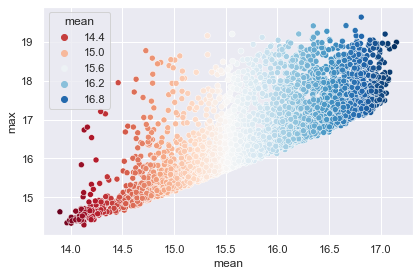

In [27]:
# mean vs. max
sns.scatterplot(
        data=descriptive_stats_mag,
        x='mean',
        y='max',
        palette='RdBu',
        hue='mean')
plt.tight_layout()
plt.show()

We also notice an interesting observation from the graph. As the mean increases, the maximum value of the light curve also increases. While this makes intuitive sense, it is helpful to visualize it. 

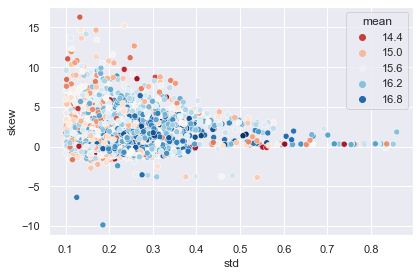

In [28]:
# std vs. skew
sns.scatterplot(
        data=descriptive_stats_mag,
        x='std',
        y='skew',
        palette='RdBu',
        hue='mean')
plt.tight_layout()
plt.show()

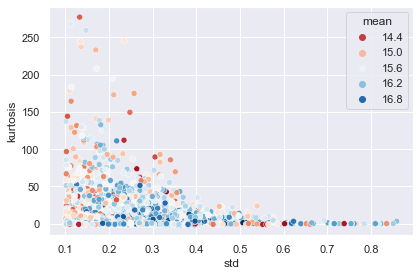

In [29]:
# std vs. kurt
sns.scatterplot(
        data=descriptive_stats_mag,
        x='std',
        y='kurtosis',
        palette='RdBu',
        hue='mean')
plt.tight_layout()
plt.show()

From the above 2 graphs, it is shown that both skewness and kurtosis decrease as the standard deviation increases. This means that as the standard deviation increases that the graph is becoming more symmetric and more spread out. 

## Analysis of error values

After analysing the magnitude values of the dataset, it is time to look more closely at the errors in thed dataset. 

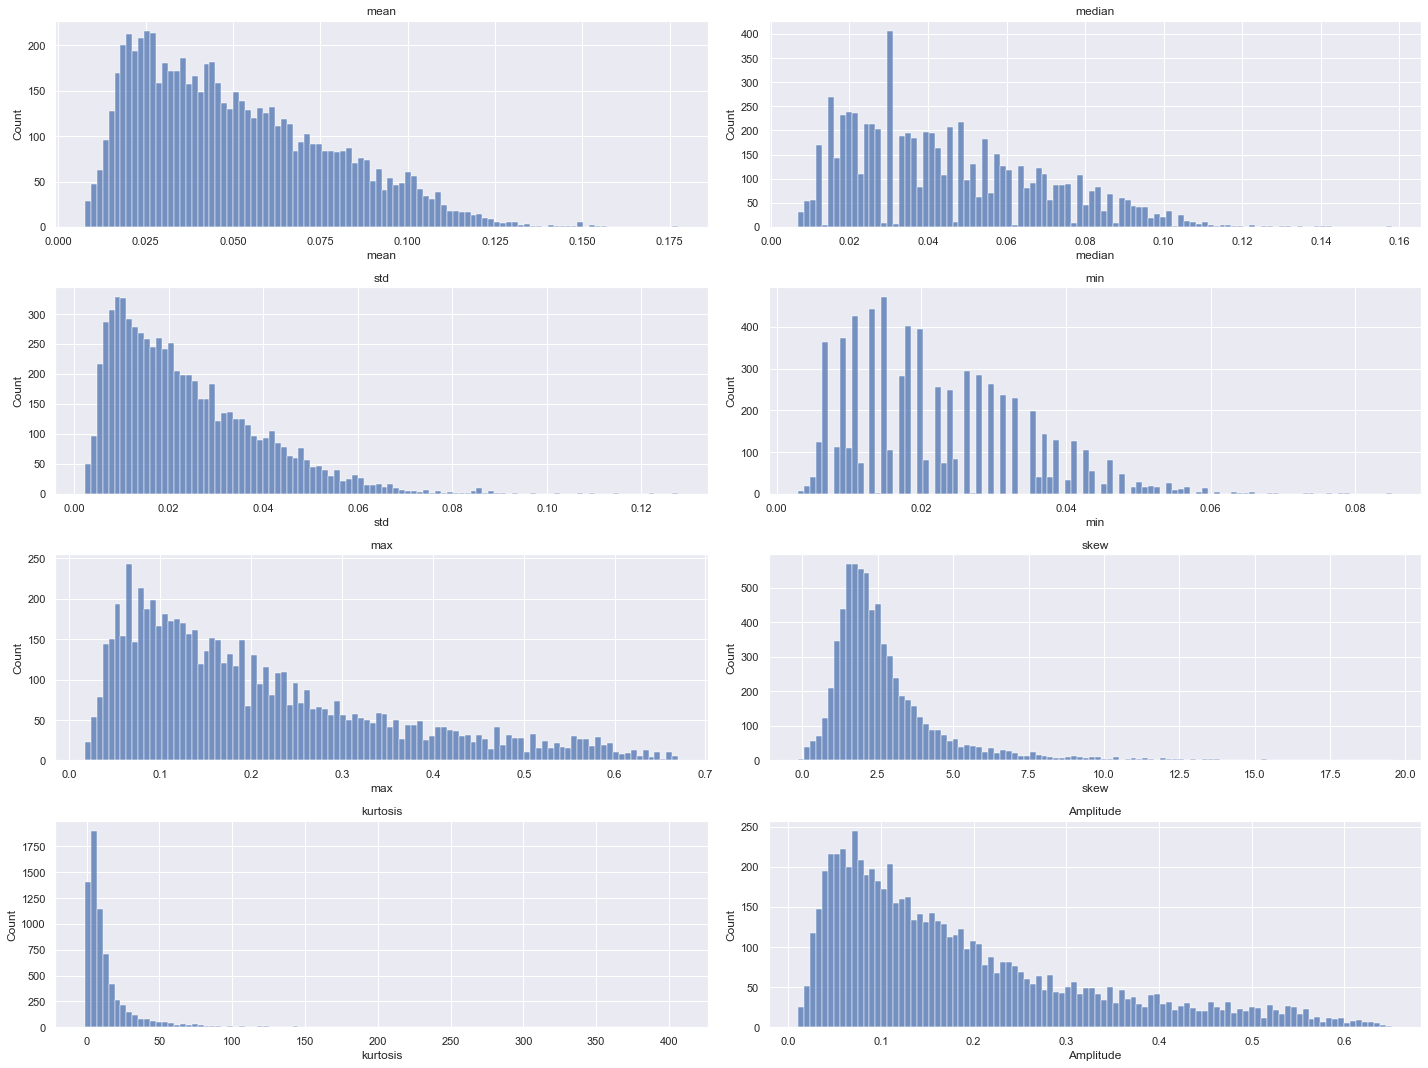

In [30]:
fig, ax = plt.subplots(4,2, figsize=(20,15)) # creating subplots with 2 columms and 3 rows
ax = ax.flatten() # flatten the axes
for i in range(len(columns)): #plot the same type of graph for every property
    ax[i].set_title(columns[i])
    sns.histplot(data=descriptive_stats_error,x=columns[i],bins=100,ax=ax[i])
plt.tight_layout()
plt.show()

From the graphs above, we can see that all of them are skewed towards the right and that:
1. Most light curves have a mean of around 0.025.
2. Most light curves have a median of around 0.02 to 0.04. This means that the errors are not very variable, and there are no significant outliers.
3. Most values of the standard deviation range from 0 to 0.02. This means that the data is very concentrated around the mean. 
4. Most light curves have a minimum within the range of 0 to 0.02.
5. In the maximum graph, wer see that most values range from 0.05 to 0.2. This means that the errors are not very large!
6. In the skewness graph we can see that the most common value is around 2.5, implying heavy asymmetricallity. 
7. In the kurtosis graph, again most values are 0, meaning the distribution is normally peaked. 
8. Finally, we see that most amplitudes of errors, or the difference between the lowest and highest error are very small. This is great for later the later analysis of data.

# Plotting light curves

After understanding the descriptive statistics of the data, its time to look at how the data looks like in the form of light curves. 

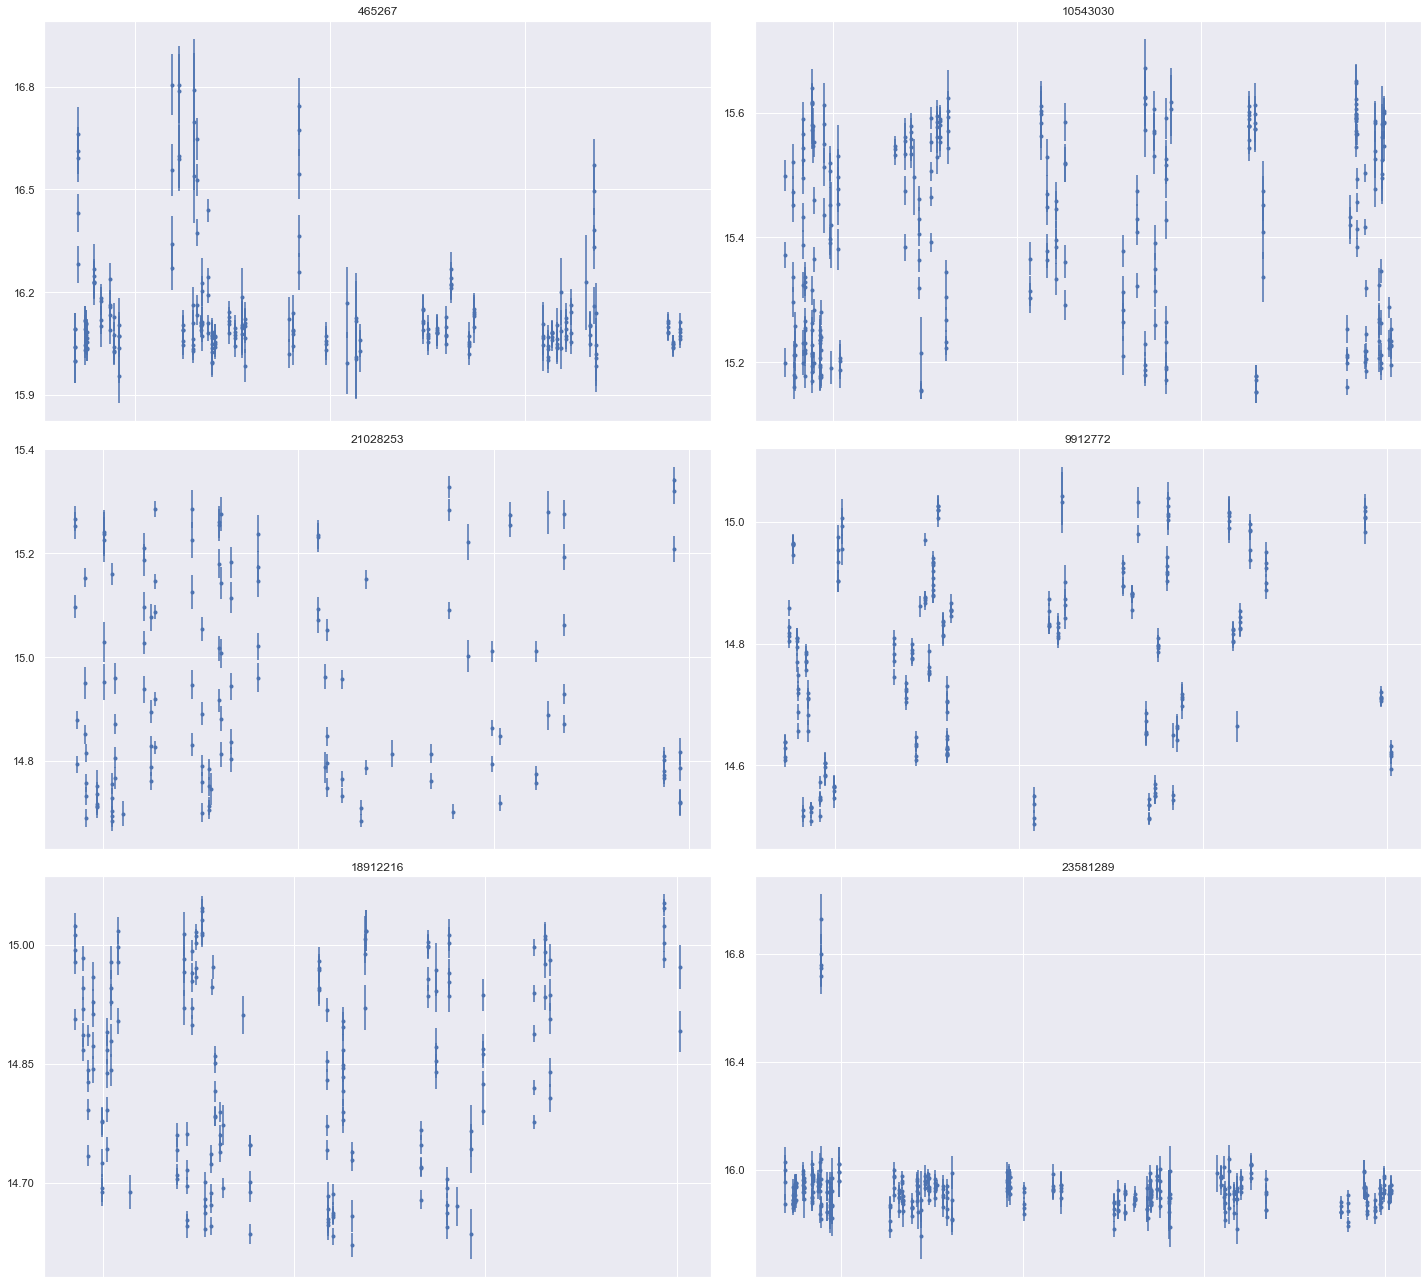

In [31]:
fig, axs = plt.subplots(3,2, figsize=(20,18)) # creating subplots with 2 columms and 3 rows
axs = axs.flatten() # flatten the axes
for i in range(6):
    light_curve = data.get_light_curve(listi[i])
    time, mag, mag_error = light_curve.T
    ax = axs[i]    
    ax.errorbar(time, mag, yerr=mag_error, fmt='.b', ecolor='b')
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.xaxis.set_major_locator(ticker.MaxNLocator(4)) # 5 ticks on the x axis
    ax.yaxis.set_major_locator(ticker.MaxNLocator(4))
    ax.set_title(listi[i])
plt.tight_layout()
plt.show()

Right now, the light curves do not amount to much, as they are not **phased**. After calculating the period, we can take a deeper look into the structure of the light curve and find out more about them. Now, onto the next dataset: ZTF.

# ZTF dataset

### A bit about ZTF

Write after reading research paper.

## Accessing the data

In [32]:
def getZTFlightcurve(ra, dec, radius=3.0): # defines a function for acessing the light curve data based on which area of the sky it should search
    try: # do the following code, and if an error occurs follow Exception
       lcq = lightcurve.LCQuery() #this object is used to query for the data
       res = lcq.from_position(ra, dec, radius) # find light curves within this area of the sky
       ZTFdata = res.data # this is basically a DataFrame then: acess the data from the area above
       # M. Graham recommends to get rid of obvious spurious points
       ZTFdata = ZTFdata.loc[ZTFdata['catflags'] < 32768] # remove faulty points, by not taking certain light curves
    except Exception as e:
       print(e)
    return ZTFdata

Now that we have defined a function which can search the night sky for light curves, we need to find all of the coordinates for every light curve in the LINEAR dataset, match these coordinates to the IDs and get the data for each of the 7010 light curves. 

In [174]:
lc_list = []
for i in range(7010):
    print(i)
    StarAttributes = data.targets[i]
    ra, dec = StarAttributes[3], StarAttributes[4]
    LC = getZTFlightcurve(ra, dec)   
    LC_r = LC.loc[LC['filtercode'] == 'zr']
    tZ = LC_r['mjd']
    magZ = LC_r['mag']
    magErrZ = LC_r['magerr']
    lc = np.array((tZ, magZ, magErrZ))
    lc_list.append(lc)

KeyboardInterrupt: 

In [173]:
with open('/Users/emadonev/Library/Mobile Documents/com~apple~CloudDocs/PROJECTS/var_stars/inputs/lc_list.pkl', 'wb') as f:
    pickle.dump(lc_list, f)

## Introductory information